# Dealing with Outliers

Sometimes outliers can mess up an analysis; you usually don't want a handful of data points to skew the overall results. Let's revisit our example of income data, with Donald Trump thrown in:

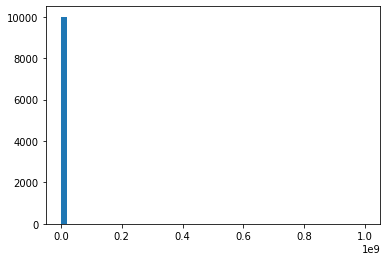

In [2]:
%matplotlib inline
import numpy as np

incomes = np.random.normal(27000, 15000, 10000)
incomes = np.append(incomes, [1000000000])

import matplotlib.pyplot as plt
plt.hist(incomes, 50)
plt.show()

That's not very helpful to look at. One billionaire ended up squeezing everybody else into a single line in my histogram. Plus it skewed my mean income significantly:

In [3]:
incomes.mean()

126987.10140092754

It's important to dig into what is causing your outliers, and understand where they are coming from. You also need to think about whether removing them is a valid thing to do, given the spirit of what it is you're trying to analyze. If I know I want to understand more about the incomes of "typical Americans", filtering out billionaires seems like a legitimate thing to do.

Here's something a little more robust than filtering out billionaires - it filters out anything beyond two standard deviations of the median value in the data set:

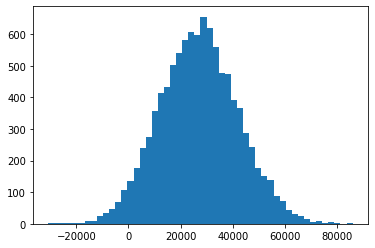

In [4]:
def reject_outliers(data):
    u = np.median(data)
    s = np.std(data)
    filtered = [e for e in data if (u - 2 * s < e < u + 2 * s)]
    return filtered

filtered = reject_outliers(incomes)

plt.hist(filtered, 50)
plt.show()

That looks better. And, our mean is more, well, meangingful now as well:

In [5]:
np.mean(filtered)

26999.80011106763

## Activity

Instead of a single outlier, add several randomly-generated outliers to the data. Experiment with different values of the multiple of the standard deviation to identify outliers, and see what effect it has on the final results.

In [ ]:
# C:\Program Files\Java\jdk-20\

In [6]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark import SparkConf, SparkContext
from numpy import array

# Boilerplate Spark stuff:
conf = SparkConf().setMaster("local").setAppName("SparkDecisionTree")
sc = SparkContext(conf = conf)

# Some functions that convert our CSV input data into numerical
# features for each job candidate
def binary(YN):
    if (YN == 'Y'):
        return 1
    else:
        return 0

def mapEducation(degree):
    if (degree == 'BS'):
        return 1
    elif (degree =='MS'):
        return 2
    elif (degree == 'PhD'):
        return 3
    else:
        return 0

# Convert a list of raw fields from our CSV file to a
# LabeledPoint that MLLib can use. All data must be numerical...
def createLabeledPoints(fields):
    yearsExperience = int(fields[0])
    employed = binary(fields[1])
    previousEmployers = int(fields[2])
    educationLevel = mapEducation(fields[3])
    topTier = binary(fields[4])
    interned = binary(fields[5])
    hired = binary(fields[6])

    return LabeledPoint(hired, array([yearsExperience, employed,
        previousEmployers, educationLevel, topTier, interned]))

#Load up our CSV file, and filter out the header line with the column names
rawData = sc.textFile("e:/sundog-consult/udemy/datascience/PastHires.csv")
header = rawData.first()
rawData = rawData.filter(lambda x:x != header)

# Split each line into a list based on the comma delimiters
csvData = rawData.map(lambda x: x.split(","))

# Convert these lists to LabeledPoints
trainingData = csvData.map(createLabeledPoints)

# Create a test candidate, with 10 years of experience, currently employed,
# 3 previous employers, a BS degree, but from a non-top-tier school where
# he or she did not do an internship. You could of course load up a whole
# huge RDD of test candidates from disk, too.
testCandidates = [ array([10, 1, 3, 1, 0, 0])]
testData = sc.parallelize(testCandidates)

# Train our DecisionTree classifier using our data set
model = DecisionTree.trainClassifier(trainingData, numClasses=2,
                                     categoricalFeaturesInfo={1:2, 3:4, 4:2, 5:2},
                                     impurity='gini', maxDepth=5, maxBins=32)

# Now get predictions for our unknown candidates. (Note, you could separate
# the source data into a training set and a test set while tuning
# parameters and measure accuracy as you go!)
predictions = model.predict(testData)
print('Hire prediction:')
results = predictions.collect()
for result in results:
    print(result)

# We can also print out the decision tree itself:
print('Learned classification tree model:')
print(model.toDebugString())

ModuleNotFoundError: No module named 'pyspark'